# Introduction

A quite common characteristic of the ATLAS Supersymmetry (SUSY) analyses is the Standard Model (SM) background estimation strategy along with the statistical approaches for testing, first, the compatibility of the observed data with the predicted SM background and, second, in absence of a data excess, setting exclusion limits on SUSY models. Additionally, limits are usually set in a model-independent manner too, in terms of a generic Beyond SM (BSM) model. Alternatively, in the case of an actual data excess, measurement of the signal strength of a model can be performed.

This notebook implements the three types of statistical fits regularly used by ATLAS SUSY analyses to achieve the above:  
1. **Background-only fit** to assess the compatibility of the observed data with the background prediction.
2. **Exclusion fit** to place model-dependent exclusion limits or measure the signal strength of a model.
3. **Discovery fit** to place model-independent exclusion limits.

Those types of fits are originally introduced in the HistFitter framework, which is using the HistFactory and RooStats packages that are implemented in ROOT [[1](https://doi.org/10.1140/epjc/s10052-015-3327-7)]. This notebook provides an implementation of the above fit strategies solely in python. The two main libraries used are [`pyhf`](https://github.com/scikit-hep/pyhf) and [`cabinetry`](https://github.com/scikit-hep/cabinetry).

# Analysis Design

Typically, an analysis design is driven by the *Signal Regions* (SRs), which are kinematic regions that aim to discriminate the signal from the SM background. Generally, the background can be categorized in:  
1. *Reducible* background: typically a high cross section SM processes that *fakes* the signal characteristics and estimated by independent data-driven methods.
2. *Irreducible* background: all those SM processes that actually have the same physical characteristics with the signal. Their estimate relies in semi-data-driven methods and is one of the main topics of this presentation.

To estimate the contribution of the irreducible backgrounds, the shape of the kinematic distributions is taken from Monte Carlo (MC) simulation while the normalization is extracted from data, thus the semi-data-driven term. To extract the normalization factors ($\mu$-factors), background enriched regions, called *Control Regions* (CRs), are constructed and utilized to scale the initial MC predictions to the observed data. Additionally, *Validation Regions* (VRs) are also defined, with a topology as similar as possible to SRs, but with low signal contamination, in order to verify the background agreement with the data before looking the yields in the SRs.

The strategy described can be schematically seen below:  

![](figures/cartoon_CRVRSR.png)

After the background has been estimated and validated, the agreement with the observed data can be assessed in the SRs. In absence of data excess, the exclusion of a model can be tested. In such case signal normalization factors are considered and fit as well.

## Likelihood Function

A binned likelihood function is build and fit to estimate both the background and the signal normalization factors, along with nuisance parameters of the fit describing the measurement systematic uncertainties. Such likelihood function is build as a product of Poisson probability functions $P(n_i, \lambda_i)$ describing the probability to observe $n$ events when $\lambda$ are expected in region $i$ (SR, CR, VR). The $\lambda_i$ depends on the normalization factors, generally from both the (irreducible) background ( $\boldsymbol{\mu}$ ) and the signal processes ( $\mu_{\mathrm{sig}}$ ). Systematic uncertainties of the measurement (nuisance parameters) are constrained by normal distributions $C(\boldsymbol{\theta}^\mathrm{0},\boldsymbol{\theta})$, where $\boldsymbol{\theta}^\mathrm{0}$ is the expected values of the nuisance parameters. The resulting likelihood is:

$$
L  = \prod_{i\in\text{SR}} \mathcal{P}(n_i|\lambda_i(\mu_\text{sig},\boldsymbol{\mu},\boldsymbol{\theta})) \times \prod_{i\in\text{CR}} \mathcal{P}(n_i|\lambda_i(\mu_\text{sig},\boldsymbol{\mu},\boldsymbol{\theta})) \times C(\boldsymbol{\theta}^\mathrm{0},\boldsymbol{\theta})
$$


and the parameters $\boldsymbol{\mu}$, $\mu_{\mathrm{sig}}$ and $\boldsymbol{\theta}$ are determined by a maximum likelihood fit.

# Example Analysis

The analysis used in this presentation, to demonstrate the three aforementioned fit strategies, is a toy SUSY analysis. This toy analysis consist of a SR to target the SUSY model, two CRs to extract the normalization of two SM background and two VRs to validate the extracted background model. The SUSY model investigated features squark production decaying to a complex final state via intermediate charginos and charged Higgs bosons. The final state state consists of several jets with one of them originating from a b-decay, a photon, a tau-lepton and missing transverse momentum from the stable neutralinos. The model is shown below:

![](figures/sqsq-C1C1-Hplus.png)

It should be stressed that this is a toy model and the couplings used violate conserved quantities.

The *irreducible* SM backgrounds considered are:
1. top pair production in association with a photon (*tty*)
2. W boson production in association with a photon (*Wy*). Only hadronic tau decays of the W boson are considered.

The analysis regions (SR, CRs, VR) are defined by kinematic selections on a number of variables. The exact definition is not important in the context of this presentations but is given on the table below for reference.

| Selection                             | SR        | CR-tty               | CR-Wy                | VR-tty    | VR-Wy         |
| ---                                   | ---       | ---                  | ---                  | ---       | ---           |
| $E_\text{T}^{\text{miss}}$ trigger    | ✔         | ✔                    | ✔                    | ✔         | ✔             |
| $E_\text{T}^{\text{miss}}$            | > 400 GeV | $\in$ (250, 400) GeV | $\in$ (250, 400) GeV | > 400 GeV | > 400 GeV     |
| $\text{N}_{\text{leptons}}$           | 0         | 0                    | 0                    | 0         | 0             |
| $\text{N}_{\gamma}$                   | 1         | 1                    | 1                    | 1         | 1             |
| $\text{N}_{\text{taus}}$              | 1         | 1                    | 1                    | 1         | 1             |
| $\text{N}_{\text{jets}}$              | ≥4        | ≥4                   | ≥4                   | ≥4        | ≥4            |
| $\text{N}_{\text{b-jets}}$            | 1         | ≥2                   | 0                    | ≥2        | 0             |
| $m_{\tau\gamma}$                      | > 100 GeV | -                    | -                    | > 100 GeV | > 100 GeV     |

# Background-only Fit

The background-only fit is used to asses the compatibility of the observed data with the background prediction. For that fit, only the CRs are used to extract the normalization factors $\boldsymbol{\mu}$, which are afterwards extrapolated first to the VRs and eventually to the SRs, as shown in the figure above.

Below we demonstrate how to setup and perform the background-only fit.

Import the required packages.

In [31]:
import cabinetry
cabinetry.set_logging()
import pyhf
import tools
from tabulate import tabulate
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Use a `cabinetry` configuration file to steer the workspace construction.

In [3]:
config = cabinetry.configuration.load('configs/config.yml')
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file configs/config.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   5 Regions(s)
INFO - cabinetry.configuration -   2 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)


Here one would normally create histograms from the root files by:
```python
cabinetry.templates.build(config)
```
but to save time we already provide those histograms in the `histogram/` directory of the repository. So we will use them to create a workspace from them.

In [4]:
ws = cabinetry.workspace.build(config)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample Wy in region SR
WARNING - cabinetry.histo - the modified histogram histograms/VR-tty_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region VR-tty
DEBUG - cabinetry.workspace - ad

Below we print the yields from the workspace. We don't want to reveal the data in the SR yet (even if we use toy data) before we're sure about our background model. Thus we're using a utility function `blind_data` which is substituting the data with the floor of the MC prediction.

In [5]:
# get model and observed data
model, data = cabinetry.model_utils.model_and_data(ws)

# obtain pre-fit model predictions
model_pred_prefit = cabinetry.model_utils.prediction(model)

# blind data in the SR
blinded_data = tools.blind_data(data, config, model_pred_prefit, model)

# show yields
cabinetry.tabulate.yields(model_pred_prefit, blinded_data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_VR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_VR-tty (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.4378833253431], [17.54221699646245], [2.6306382184870496], [6.449790413245681], [1.707720923882212]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.4378833253431, 17.54221699646245, 2.6306382184870496, 6.

{'yields_per_channel': [{'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.56',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85',
   'VR-Wy': '31.50 ± 6.31',
   'VR-tty': '1.98 ± 0.41'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78',
   'VR-Wy': '0.71 ± 0.14',
   'VR-tty': '6.36 ± 1.30'},
  {'sample': 'total',
   'CR-Wy': '242.09 ± 48.44',
   'CR-tty': '87.48 ± 17.54',
   'SR': '13.06 ± 2.63',
   'VR-Wy': '32.21 ± 6.45',
   'VR-tty': '8.34 ± 1.71'},
  {'sample': 'data',
   'CR-Wy': '167.00',
   'CR-tty': '74.00',
   'SR': '13.00',
   'VR-Wy': '28.00',
   'VR-tty': '12.00'}]}

Uncertainties above include both statistical and our background `FlatSys` component.

As described already, for the background-only fit we only fit the CRs. So we're removing (pruning) the SRs and VRs from the workspace.

In [6]:
# prune SRs & VRs from workspace
redundant_channels = [region['Name'] for region in config['Regions'] if 'SR' in region['Name'] or 'VR' in region['Name']]
pruned_workspace = pyhf.Workspace(ws).prune(channels=redundant_channels)

# get pruned model and pruned observed data
pruned_model, pruned_data = cabinetry.model_utils.model_and_data(pruned_workspace)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)


Now we can fit the model to the data and visualize the resulted (post-fit) parameters.

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -0.1563                    │              Nfcn = 167              │
│ EDM = 4.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

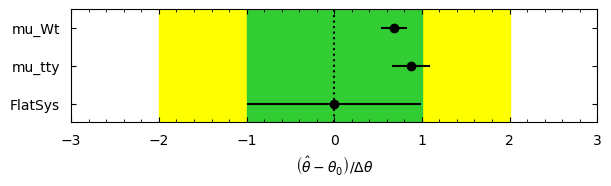

In [7]:
# fit
bkgOnlyFit_results = cabinetry.fit.fit(pruned_model, pruned_data)

# visualize
cabinetry.visualize.pulls(bkgOnlyFit_results)

Of course, we care about the background estimation in VRs and eventually in SRs. So we will extrapolate the normalization factors from the CRs to the VRs and SRs. 

We will first look only at VRs in order to validate the background modeling and if the agreement between the observed data and the predicted background is adequate, we will further look into the SRs.

DEBUG - cabinetry.model_utils - total stdev is [[12.92093634454921], [8.596608672180983], [0.6727673267430768], [1.7742814749935782], [0.8053605083144251]]
DEBUG - cabinetry.model_utils - total stdev per channel is [12.92093634454921, 8.596608672180983, 0.6727673267430768, 1.7742814749935782, 0.8053605083144251]
INFO - cabinetry.tabulate - yields per channel for post-fit model prediction:
╒══════════╤════════════════╤══════════════╤═════════════╤══════════════╤═════════════╕
│ sample   │ CR-Wy          │ CR-tty       │ SR          │ VR-Wy        │ VR-tty      │
╞══════════╪════════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ Wy       │ 158.75 ± 13.07 │ 9.41 ± 0.79  │ 6.27 ± 0.54 │ 21.49 ± 1.79 │ 1.35 ± 0.13 │
├──────────┼────────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ tty      │ 8.23 ± 1.12    │ 64.60 ± 8.70 │ 3.38 ± 0.47 │ 0.62 ± 0.08  │ 5.57 ± 0.80 │
├──────────┼────────────────┼──────────────┼─────────────┼──────────────┼───────

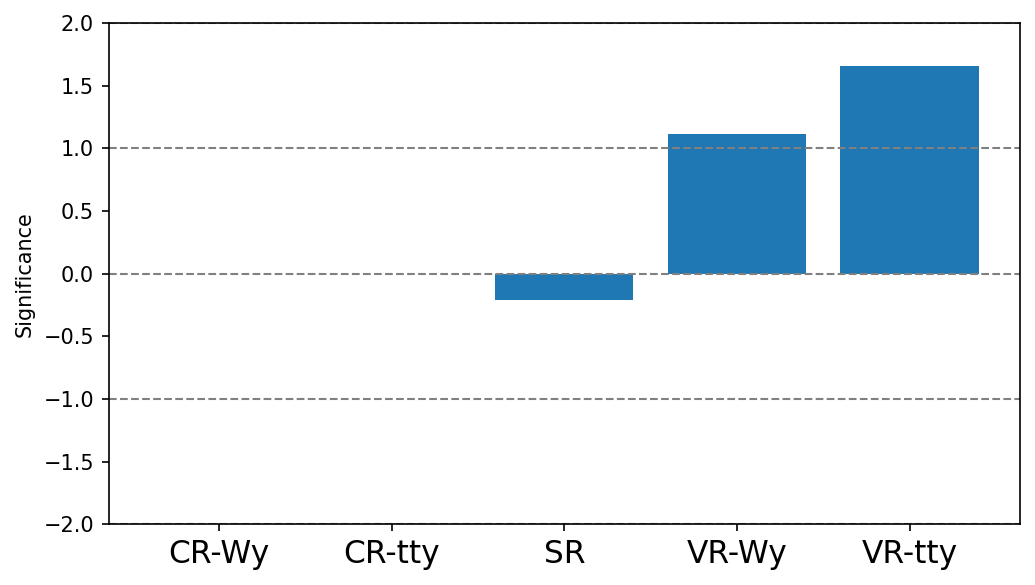

In [8]:
# put back the VRs & SRs to the results
bkgOnlyFit_results_for_full_model = cabinetry.model_utils.match_fit_results(model, bkgOnlyFit_results)

# obtain post-fit model prediction and use it to blind SR data
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=bkgOnlyFit_results_for_full_model)
blinded_data = tools.blind_data(data, config, model_pred_postfit, model)

# show post-fit yield table
cabinetry.tabulate.yields(model_pred_postfit, blinded_data, per_bin=False, per_channel=True)

# visualize agreement
tools.plot_pulls(model_pred_postfit, blinded_data, ylim=2, xticks_fontsize=15)

Let's assume that the above agreement in the VRs is adequate and look ath the data in SRs. A usual threshold to declare deviation from the background prediction is a significance value of 3.

INFO - cabinetry.tabulate - yields per channel for post-fit model prediction:
╒══════════╤════════════════╤══════════════╤═════════════╤══════════════╤═════════════╕
│ sample   │ CR-Wy          │ CR-tty       │ SR          │ VR-Wy        │ VR-tty      │
╞══════════╪════════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ Wy       │ 158.75 ± 13.07 │ 9.41 ± 0.79  │ 6.27 ± 0.54 │ 21.49 ± 1.79 │ 1.35 ± 0.13 │
├──────────┼────────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ tty      │ 8.23 ± 1.12    │ 64.60 ± 8.70 │ 3.38 ± 0.47 │ 0.62 ± 0.08  │ 5.57 ± 0.80 │
├──────────┼────────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ total    │ 166.98 ± 12.92 │ 74.01 ± 8.60 │ 9.66 ± 0.67 │ 22.11 ± 1.77 │ 6.92 ± 0.81 │
├──────────┼────────────────┼──────────────┼─────────────┼──────────────┼─────────────┤
│ data     │ 167.00         │ 74.00        │ 15.00       │ 28.00        │ 12.00       │
╘══════════╧════════════════╧═════════════

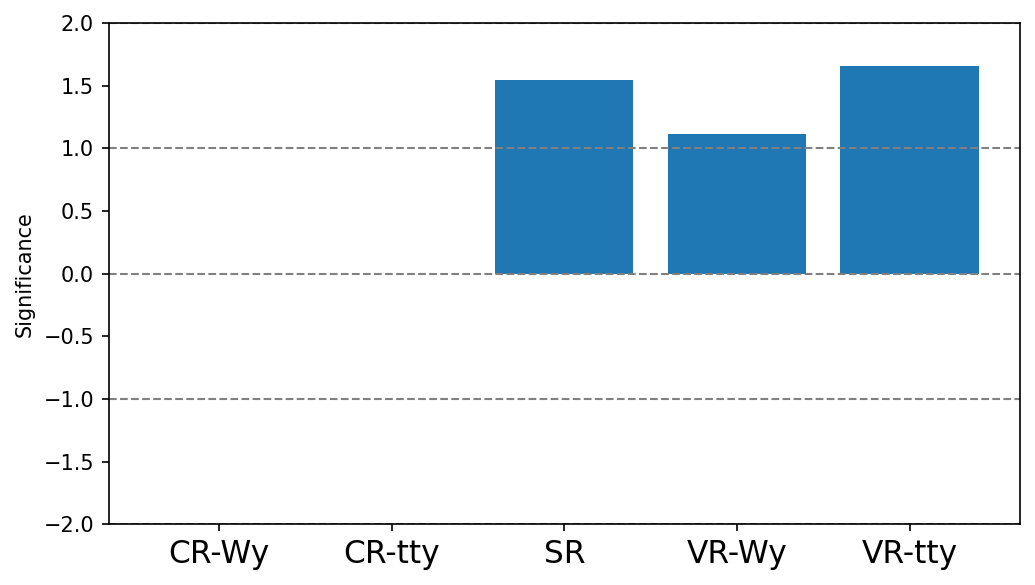

In [9]:
# show post-fit yield table
cabinetry.tabulate.yields(model_pred_postfit, data, per_bin=False, per_channel=True)

# visualize agreement
tools.plot_pulls(model_pred_postfit, data, ylim=2, xticks_fontsize=15)

A useful information is the impact of the various uncertainties to the predicted yields. The code below helps us to calculate and visualize this impact per region considered. It should be noted that the individual uncertainties can be correlated and do not necessarily add up in quadrature to the total background uncertainty.

In [10]:
# calculate uncertainties breakdown
unc_per_channel = tools.uncertainties_impact_method1(model, bkgOnlyFit_results_for_full_model)

# print uncertainties per channel in tables
for key in unc_per_channel.keys():
    print(f"\nUncertainties breakdown for {key}")
    unc_threshold = 0.0
    table = tabulate([[label, '±'+str(unc[0]), unc[1]] for label, unc in unc_per_channel[key].items() if unc[0]>unc_threshold], 
                     headers=['NP', 'Uncertainty', 'Rel. Uncertainty (%)'],
                     tablefmt='txt')
    print(table)

DEBUG - cabinetry.model_utils - total stdev is [[34.504454460682815], [2.0449753796731045], [1.3634081156047702], [4.6706592353868945], [0.29337784697306546]]
DEBUG - cabinetry.model_utils - total stdev per channel is [34.504454460682815, 2.0449753796731045, 1.3634081156047702, 4.6706592353868945, 0.29337784697306546]
DEBUG - cabinetry.model_utils - total stdev is [[1.9956868483258177], [15.664823755321255], [0.8208590623793786], [0.15120870415123555], [1.3518062391336603]]
DEBUG - cabinetry.model_utils - total stdev per channel is [1.9956868483258177, 15.664823755321255, 0.8208590623793786, 0.15120870415123555, 1.3518062391336603]
DEBUG - cabinetry.model_utils - total stdev is [[33.16860724085928], [14.700220194723896], [1.9184084571703168], [4.392411889781211], [1.3754059232855667]]
DEBUG - cabinetry.model_utils - total stdev per channel is [33.16860724085928, 14.700220194723896, 1.9184084571703168, 4.392411889781211, 1.3754059232855667]
DEBUG - cabinetry.model_utils - total stdev is

 estimating the impact of mu_Wt ...
 estimating the impact of mu_tty ...
 estimating the impact of FlatSys ...
 estimating the impact of staterror_CR-Wy[0] ...
 estimating the impact of staterror_CR-tty[0] ...
 estimating the impact of staterror_SR[0] ...
 estimating the impact of staterror_VR-Wy[0] ...
 estimating the impact of staterror_VR-tty[0] ...

Uncertainties breakdown for CR-Wy
NP                  Uncertainty      Rel. Uncertainty (%)
------------------  -------------  ----------------------
mu_Wt               ±34.5                            20.7
FlatSys             ±33.17                           19.9
mu_tty              ±2.0                              1.2
staterror_CR-Wy[0]  ±0.97                             0.6

Uncertainties breakdown for CR-tty
NP                   Uncertainty      Rel. Uncertainty (%)
-------------------  -------------  ----------------------
mu_tty               ±15.66                           21.2
FlatSys              ±14.7                       

# Exclusion Fit

The exclusion fit is used to study a particular signal model. For that fit, both the CRs and SRs are used to extract the normalization factors $\boldsymbol{\mu}$ and $\mu_{\mathrm{sig}}$. No VRs are used. The POI of the fit is the $\mu_{\mathrm{sig}}$ and a test statistic is constructed and used to reject or not the *background-plus-signal* hypothesis against the *background-only* hypothesis. The test statistic used is the profile likelihood ratio [[2](https://doi.org/10.1140/epjc/s10052-011-1554-0)] and a signal model is considered excluded, at 95% Confidence Level, if the resulting CLs value [[3](https://doi.org/10.1088/0954-3899/28/10/313)] is less than 0.05.

Below we demonstrate how to setup and perform the background-only fit.

We will use another configuration file, which also includes a signal model.

In [11]:
config = cabinetry.configuration.load('configs/config_excl.yml')
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file configs/config_excl.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   4 Sample(s)
INFO - cabinetry.configuration -   3 Regions(s)
INFO - cabinetry.configuration -   3 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)


As we already have the require histograms available we can directly use them to construct the workspace.

In [12]:
ws = cabinetry.workspace.build(config)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample Wy in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Signal to sample Signal in region SR
WARNING - cabinetry.histo - the

Print the yields from the workspace.

In [13]:
# get model and observed data
model, data = cabinetry.model_utils.model_and_data(ws)

# obtain pre-fit model predictions
model_pred_prefit = cabinetry.model_utils.prediction(model)

# show yields
cabinetry.tabulate.yields(model_pred_prefit, data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.447386566150904], [17.61563114031243], [3.2652844864793433]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.447386566150904, 17.61563114031243, 3.2652844864793433]
INFO - cabinetry.tabulate - yields per channel for pre-fit model prediction:
╒══════════╤════════════════╤════════════════╤══

{'yields_per_channel': [{'sample': 'Signal',
   'CR-Wy': '16.27 ± 0.11',
   'CR-tty': '45.81 ± 0.70',
   'SR': '65.25 ± 1.63'},
  {'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.57',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78'},
  {'sample': 'total',
   'CR-Wy': '258.36 ± 48.45',
   'CR-tty': '133.30 ± 17.62',
   'SR': '78.31 ± 3.27'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

In order to calculate the so-called *expected* limit, we need to perform a background-only fit (in both CRs and SR this time!) and use the result of it as *observations*, instead of real data. To achieve that, we create a copy of our workspace and then prune the signal sample and its corresponding normalization factor from it. In other words, a background-only workspace, similar as before.

In [14]:
# prune signal and its normalization factor
BOnly_ws = pyhf.Workspace(ws)._prune_and_rename(prune_samples=['Signal'], prune_modifiers=['mu_Signal'])
# change POI to one of the background normalization factors
dict(BOnly_ws)['measurements'][0]['config']['poi'] = 'mu_tty'

# get model and observed data
BOnly_model, BOnly_data = cabinetry.model_utils.model_and_data(BOnly_ws)

# obtain pre-fit model predictions (background-only)
BOnly_model_pred_prefit = cabinetry.model_utils.prediction(BOnly_model)

# show post-fit yield table
cabinetry.tabulate.yields(BOnly_model_pred_prefit, BOnly_data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.4378833253431], [17.54221699646245], [2.6306382184870496]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.4378833253431, 17.54221699646245, 2.6306382184870496]
INFO - cabinetry.tabulate - yields per channel for pre-fit 

{'yields_per_channel': [{'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.56',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78'},
  {'sample': 'total',
   'CR-Wy': '242.09 ± 48.44',
   'CR-tty': '87.48 ± 17.54',
   'SR': '13.06 ± 2.63'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

Now we can perform the background-only fit (in CRs and SR) which will give us the dataset to use as *observations*.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.203                      │              Nfcn = 203              │
│ EDM = 3.95e-06 (Goal: 0.0002

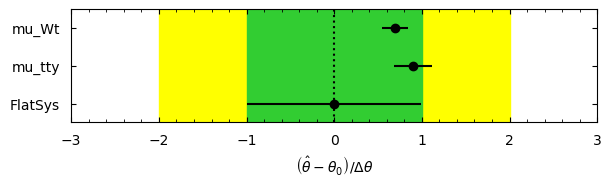

In [15]:
# get pruned model and pruned observed data
BOnly_model, BOnly_data = cabinetry.model_utils.model_and_data(BOnly_ws)

# fit and visualize
fit_results_BOnly_model = cabinetry.fit.fit(BOnly_model, BOnly_data)
cabinetry.visualize.pulls(fit_results_BOnly_model)

Use the results of the above fit to build the dataset to be used as *observations*, which is being called *Asimov*. This is retrieved using the best-fit parameters of the above fit.

In [16]:
asimov_parameters = fit_results_BOnly_model.bestfit
asimov_dataset = BOnly_model.expected_data(asimov_parameters)
print("Asimov dataset (Background-only):", asimov_dataset)

Asimov dataset (Background-only): [ 1.70213290e+02  7.58797257e+01  9.89787279e+00 -1.04435794e-03
  9.99895468e-01  9.99607883e-01  1.00302871e+00]


In order to perform the actual exclusion fit we get a model and data objects from the initial workspace, which includes the two backgrounds and the signal, and use `pyhf.infer.hypotest` to calculate the CLs values. For the *expected* we use our Asimov dataset from above and for the *observed* we use the actual data observations.

In [17]:
# get model and observed data (pre-fit)
model, data = cabinetry.model_utils.model_and_data(ws)
channels = model.config.channels

# calculate expected CLs with respect to POI
try: # in case the fit fails, we don't crash
    _, CLs_exp_band = pyhf.infer.hypotest(1.0, asimov_dataset, model, return_expected_set=True)
    # keep only ±1 sigma and convert to simple floats
    CLs_exp_band = list(map(lambda x: float(x), CLs_exp_band[1:4]))
except:
    CLs_exp_band = None

# calculate observed CLs with respect to POI
try:
    CLs_obs = pyhf.infer.hypotest(1.0, data, model)
    # convert to simple floats
    CLs_obs = float(CLs_obs)
except:
    CLs_obs = None

# print results
print("Results for POI", model.config.poi_name)
print("CLs_exp_band:", CLs_exp_band)
print("CLs_obs:", CLs_obs)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)


Results for POI mu_Signal
CLs_exp_band: [1.4187358312997277e-23, 7.508880528393266e-20, 2.769297740437018e-16]
CLs_obs: 4.621518505137136e-16


## Bonus: from a single model to the whole signal grid

Thus far we have calculated the expected and observed CLs values for a single model. However, analyses most often test the hypothesis of multiple models and then interpolate a contour of 0.05 CLs value to draw the usual exclusion limit. An example below from [JHEP 12 (2019) 060](https://link.springer.com/article/10.1007/JHEP12(2019)060), taken from [[4](https://etheses.whiterose.ac.uk/27046/)].

![](figures/M60_Grid_contours_M60_RegionA.jpg)

We can loop the above procedure to calculate the *observed* and *expected* CLs values for multiple signal models. This can happen via multiple implementations. For this notebook, we use a configuration file that includes multiple signal `Samples` and a corresponding `NormFactor` ($\mu_{\mathrm{sig}}$) for each one. The loop fixes all the signal `NormFactors` to zero **but one**, which is set as POI, and the CLs values are calculated. Then it proceeds to the next signal `NormFactor`.

In [18]:
# load configuration files
config_grid = cabinetry.configuration.load('configs/config_excl_grid.yml')
cabinetry.configuration.print_overview(config_grid)

# create workspace
ws_grid = cabinetry.workspace.build(config_grid)

INFO - cabinetry.configuration - opening config file configs/config_excl_grid.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   7 Sample(s)
INFO - cabinetry.configuration -   3 Regions(s)
INFO - cabinetry.configuration -   6 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)
INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding Ov

The for-loop which is running the exclusion fit for each of the signal samples/normalization factors defined in our workspace is constructed below. Initially we get a `model` from our workspace, which includes all the signal samples/normalization factors. Then the `fix_and_calculate` function is used in each iteration of the loop. The function fixes all the `model` parameters except of the one given as argument (`param`) and calculates the CLs values (*observed* and *expected*) for that particular parameter. The results are collected in a dictionary.

In [19]:
# get model and observed data (pre-fit)
model, data = cabinetry.model_utils.model_and_data(ws_grid)
channels = model.config.channels

# signal normalisation parameter names
signal_norms = [param for param in model.config.par_names if 'mu_Signal' in param]
# signal normalisation parameter model indices
signal_norms_idx = [model.config.par_map[norm]['slice'].start for norm in signal_norms]

def fix_and_calculate(param):
    '''
    Fix all signal normalisation parameters to zero except the one specified by param
    '''
    
    print(f"Calculating observed and explected CLs for POI {param}")
    
    # get the index of the param, this will be the new POI
    poi_idx = cabinetry.model_utils._poi_index(model, poi_name=param)
    # set POI to param
    model.config.set_poi(model.config.par_names[poi_idx])
    
    # indices of all the signal normalisation parameters except the poi_idx
    fixed_signal_norms_idx = [idx for idx in signal_norms_idx if idx!=poi_idx]

    # set the rest or signal normalisation parameters fixed at zero
    fix_pars = model.config.suggested_fixed().copy()
    init_pars = model.config.suggested_init().copy()
    for idx in fixed_signal_norms_idx:
        fix_pars[idx] = True
        init_pars[idx] = 0.0

    # calculate expected CLs with respect to POI
    try:
        _, CLs_exp_band = pyhf.infer.hypotest(1.0, asimov_dataset, model, init_pars=init_pars, fixed_params=fix_pars, return_expected_set=True)
        # keep only ±1 sigma and convert to simple floats
        CLs_exp_band = list(map(lambda x: float(x), CLs_exp_band[1:4]))
    except:
        CLs_exp_band = None

    # calculate observed CLs with respect to POI
    try:
        CLs_obs = pyhf.infer.hypotest(1.0, data, model, init_pars=init_pars, fixed_params=fix_pars)
        # convert to simple floats
        CLs_obs = float(CLs_obs)
    except:
        CLs_obs = None

    return [CLs_obs, CLs_exp_band]

# results dictionary
post_fit_significance_results = {}

# create a pool of workers for parallel looping
with ProcessPoolExecutor() as executor:
    print(f"Calculating observed and explected CLs of {len(signal_norms)} models on a pool of {executor._max_workers} workers")
    # loop: pick one signal parameter, fix the rest to zero, calculate CLs
    for param in signal_norms:
        # submit the job to the pool
        future = executor.submit(fix_and_calculate, param)
        # save the returned future object into the results dictionary
        post_fit_significance_results[param] = future

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Signal_1000_300 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1000_500 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1500_300 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal_1500_500 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)


Calculating observed and explected CLs of 4 models on a pool of 96 workers
Calculating observed and explected CLs for POI mu_Signal_1000_300
Calculating observed and explected CLs for POI mu_Signal_1000_500
Calculating observed and explected CLs for POI mu_Signal_1500_300
Calculating observed and explected CLs for POI mu_Signal_1500_500


We use the helper function `get_results_df` to convert the results dictionary to a `pd.DataFrame` for easier further handling.

In [20]:
postfit_results_df = tools.get_results_df(post_fit_significance_results)
display(postfit_results_df)

,Sq,Hplus,DeltaM,observed_p_value,expected_p_value,expected_p_value_plusOneSigma,expected_p_value_minusOneSigma,observed_signif,expected_signif,expected_signif_plusOneSigma,expected_signif_minusOneSigma
0,1000,300,700,3.086775e-16,4.625685e-20,1.796494e-16,8.298403e-24,8.085843,9.097408,8.151547,9.991549
1,1000,500,500,2.693752e-07,4.994624e-10,1.067496e-07,1.647159e-12,5.011972,6.109582,5.187183,6.964560
2,1500,300,1200,5.428994e-01,1.577974e-01,4.040909e-01,4.992820e-02,-0.107741,1.003552,0.242772,1.645550
3,1500,500,1000,5.493469e-01,1.794045e-01,4.349622e-01,6.035215e-02,-0.124011,0.917637,0.163755,1.551824


Using information from the above DataFrame we can make a plot to visualize, for instance, the observed CLs/limit.

/tmp/ipykernel_61123/4023449284.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivoted = postfit_results_df.pivot('Hplus','Sq','observed_p_value').iloc[::-1]


Text(50.722222222222214, 0.5, '$m(H^{\\pm})$ [GeV]')

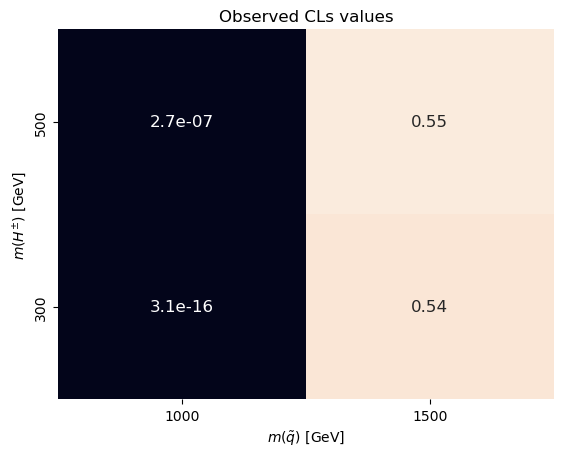

In [21]:
pivoted = postfit_results_df.pivot('Hplus','Sq','observed_p_value').iloc[::-1]
sns.heatmap(pivoted, annot=True, annot_kws={'size': 12}, cbar=False)
plt.title("Observed CLs values")
plt.xlabel(r'$m(\tilde{q})$ [GeV]')
plt.ylabel(r'$m(H^{\pm})$ [GeV]')

# Discovery Fit

The discovery fit proceeds generally in the same manner as the as the exclusion fit. The main difference is that the signal model is now a *dummy* model yielding exactly one event in the SR, when $\mu_{\mathrm{sig}}=1$, and zero events in the CRs. The likelihood is fit again in both SRs and CRs. Multiple fits are performed while scanning the $\mu_{\mathrm{sig}}$, which is a fixed parameter of the fit. The value of $\mu_{\mathrm{sig}}$ which yields a CLs value of 0.05 is then evaluated and can be converted to an Upper Limit (UL) on the number of events or visible cross-section of a generic BSM process. 

Load the configuration file and create a workspace from that.

In [22]:
config = cabinetry.configuration.load('configs/config_disc.yml')
cabinetry.configuration.print_overview(config)
ws = cabinetry.workspace.build(config)

INFO - cabinetry.configuration - opening config file configs/config_disc.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   4 Sample(s)
INFO - cabinetry.configuration -   3 Regions(s)
INFO - cabinetry.configuration -   3 NormFactor(s)
INFO - cabinetry.configuration -   1 Systematic(s)
INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram histograms/SR_tty_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_tty to sample tty in region SR
DEBUG - cabinetry.workspace - adding OverallSys FlatSys to sample tty in region SR
WARNING - cabinetry.histo - the modified histogram histograms/SR_Wy_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor mu_Wt to sample Wy in region SR
DEBUG - cabinetry.workspace - adding Overall

Since with the `config_disc.yml` we loaded an actual signal model, we need to convert that to the *dummy* one described above using the helper function below.

In [23]:
ws = tools.force_signal_yield_to_one(ws, config)

As a verification, we can check that the signal yield in SR is indeed 1.0, while 0.0 in CRs.

In [24]:
# get model and observed data
model, data = cabinetry.model_utils.model_and_data(ws)

# obtain pre-fit model predictions
model_pred_prefit = cabinetry.model_utils.prediction(model)

# show yields
cabinetry.tabulate.yields(model_pred_prefit, data, per_bin=False, per_channel=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_Signal (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
DEBUG - cabinetry.model_utils - total stdev is [[48.4378833253431], [17.54221699646245], [2.6306382184870487]]
DEBUG - cabinetry.model_utils - total stdev per channel is [48.4378833253431, 17.54221699646245, 2.6306382184870487]
INFO - cabinetry.tabulate - yields per channel for pre-fit model prediction:
╒══════════╤════════════════╤═══════════════╤═══════

{'yields_per_channel': [{'sample': 'Signal',
   'CR-Wy': '0.00 ± 0.00',
   'CR-tty': '0.00 ± 0.00',
   'SR': '1.00 ± 0.00'},
  {'sample': 'Wy',
   'CR-Wy': '232.70 ± 46.56',
   'CR-tty': '13.79 ± 2.77',
   'SR': '9.19 ± 1.85'},
  {'sample': 'tty',
   'CR-Wy': '9.39 ± 1.88',
   'CR-tty': '73.69 ± 14.78',
   'SR': '3.86 ± 0.78'},
  {'sample': 'total',
   'CR-Wy': '242.09 ± 48.44',
   'CR-tty': '87.48 ± 17.54',
   'SR': '14.06 ± 2.63'},
  {'sample': 'data', 'CR-Wy': '167.00', 'CR-tty': '74.00', 'SR': '15.00'}]}

We setup the discovery fit in a similar manner to the exclusion fit (for a single model). Using the `pyhf.infer.intervals.upper_limits.upper_limit` we can perform multiple fits, each time with another fixed value of the $\mu_{\mathrm{sig}}$, and thus calculate multple CLs values.

In [25]:
# define a search space for the POI
upper_bound = 30
granularity = 30
scan = np.linspace(0, upper_bound, granularity+1)

# calculate the observed UL on BSM events at 95% CL
obs_limit, _, (scan, obs_results) = pyhf.infer.intervals.upper_limits.upper_limit(data, model, scan, return_results=True)

For the *expected* limit, once again, we first need a background-only fit to get the best-fit parameters and construct an Asimov dataset which is gonna be used as *observations*.

In [26]:
# prune signal and its normalization factor
BOnly_ws = pyhf.Workspace(ws)._prune_and_rename(prune_samples=['Signal'], prune_modifiers=['mu_Signal'])
# change POI to one of the background normalization factors
dict(BOnly_ws)['measurements'][0]['config']['poi'] = 'mu_tty'

# get pruned model and pruned observed data
BOnly_model, BOnly_data = cabinetry.model_utils.model_and_data(BOnly_ws)

# fit and visualize
fit_results_BOnly_model = cabinetry.fit.fit(BOnly_model, BOnly_data)

# build an Asimov dataset: all parameters set to their best-fit values from previous fit results
asimov_parameters = fit_results_BOnly_model.bestfit
asimov_dataset = BOnly_model.expected_data(asimov_parameters)

# calculate the expected ULs
_, exp_limits, (scan, exp_results) = pyhf.infer.intervals.upper_limits.upper_limit(asimov_dataset, model, scan, return_results=True)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier mu_Wt (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier FlatSys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-Wy (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CR-tty (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_SR (1 new nuisance parameters)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬────

Finally, it is also common to calculate the so-called *discovery* p-value and significance which quantify the compatibility of the observed data with the background-only hypothesis.

In [27]:
# calculate the discovery p-value and significance
discovery_fit_results = cabinetry.fit.significance(model, data)
p0 = discovery_fit_results.observed_p_value
z0 = discovery_fit_results.observed_significance

INFO - cabinetry.fit - calculating discovery significance for mu_Signal
INFO - cabinetry.fit - observed p-value: 6.098%
INFO - cabinetry.fit - observed significance: 1.547
INFO - cabinetry.fit - expected p-value: 37.970%
INFO - cabinetry.fit - expected significance: 0.306


Print and plot the results.

In [28]:
print(f"Observed (Expected) UL on BSM events at 95% CL = {obs_limit:.2f} ({exp_limits[2]:.2f} + {(exp_limits[3] - exp_limits[2]):.2f} - {(exp_limits[2] - exp_limits[1]):.2f})")
print(f"Observed UL on visible BSM cross-section at 95% CL = {obs_limit/138.965:.2f} fb") # use LHC Run 2 luminosity
print(f"Observed discovery p-value (Z) = {p0:.2f} ({z0:.2f})")

Observed (Expected) UL on BSM events at 95% CL = 12.96 (7.66 + 3.72 - 2.40)
Observed UL on visible BSM cross-section at 95% CL = 0.09 fb
Observed discovery p-value (Z) = 0.06 (1.55)


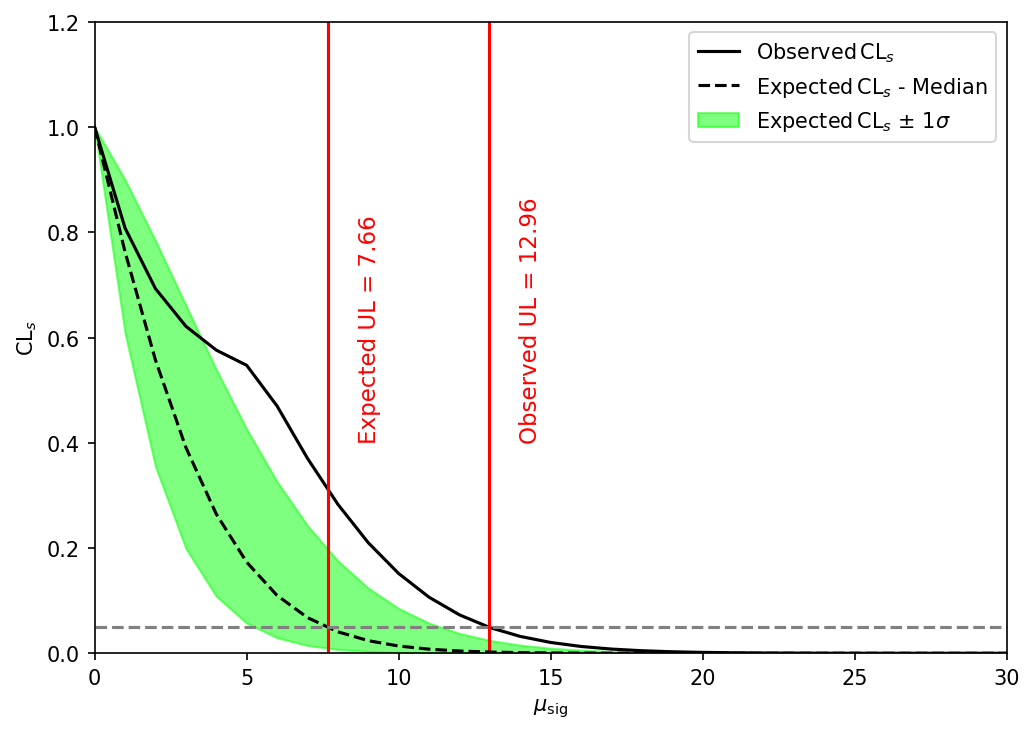

In [29]:
tools.plot_UL_scan(obs_limit, obs_results, exp_limits, exp_results, scan)

## Conclusions

In this notebook we have demonstrated the implementation of the three common types of fits used in ATLAS SUSY analyses:
1. Background-only fit
2. Exclusion fit
3. Discovery fit
using solely python and the `pyhf` and `cabinetry` libraries.

The contribution signifies the adaptability of `pyhf`, liberating the analysis from dependence on traditional ROOT-based tools. In addition to enhancing clarity regarding the statistical model itself, this implementation signifies a broader shift towards contemporary standards in data analytics.